### Part4: Coincidence detection with AMPA-like and NMDA-like synapses

Coincidence detection can be emulated on Dynap-SE1 by combining the AMPA-like (DPI fast) and the NMDA-like (DPI slow) synapse.

Let's start with importing Brian2:

In [1]:
from brian2 import *
from DynapSE import DynapSE
from parameters.constants import *

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from parameters.set_params import set_params

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90 
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

### Input Spike Train

Let's generate a Spike Train with N=num_spikes spikes*2, which consists of two spike trains:
- input pulses via the **AMPA** synapse: regular spike train with rate=2Hz 
- input pulses via the **NMDA** synapse: generated from the first spike train, by regularly shifting the i-th spike with respect to the i-th AMPA spike by 10ms*i.

Run the next cell to visualize the resulting input spike train:

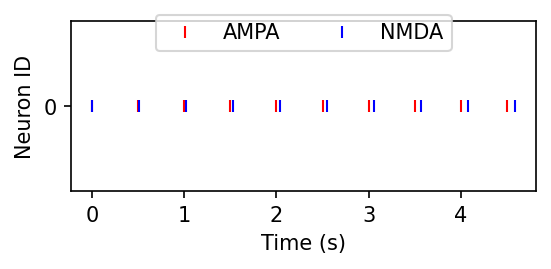

In [2]:
num_spikes = 10
rate = 2            # Hz
inp_duration = num_spikes/rate # second
spikes = np.zeros(int(inp_duration*1000))
dt = int(1000/rate)
end = int(inp_duration*1000)
spikes[0:end:dt] = 1.0

spike_timing_ampa = np.where(spikes==1)[0] * ms # Timing of spikes
spike_timing_nmda = np.array([spike_timing_ampa[idx]/ms+idx*10 for idx in range(len(spike_timing_ampa))])*ms

neuron_indices_nmda = np.zeros(len(spike_timing_nmda)) # ID of spike sources
neuron_indices_ampa = np.zeros(len(spike_timing_ampa)) # ID of spike sources

# Spike Generator
input_spike_generator_ampa = SpikeGeneratorGroup(1, indices=neuron_indices_ampa, times=spike_timing_ampa, name='InpAMPA')  
input_spike_generator_nmda = SpikeGeneratorGroup(1, indices=neuron_indices_nmda, times=spike_timing_nmda, name='InpNMDA')  

# Plot
plt.figure(figsize=(4,1.5),dpi=150)
plt.plot(spike_timing_ampa, neuron_indices_ampa, 'r|', label='AMPA')
plt.plot(spike_timing_nmda, neuron_indices_nmda, 'b|', label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.xlabel("Time (s)")
plt.ylabel("Neuron ID")
plt.ylim(-0.25, .25)
plt.yticks([0])
plt.show()

### Brian2 Network

In [3]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

# DPI neuron
DPI_neuron  = chip.get_neurons(1, 'Core_1') # Allocate single DPI neuron from Core 1

# DPI synapses
DPI_AMPA_synapse = chip.add_connection(input_spike_generator_ampa, DPI_neuron, synapse_type='AMPA') # Define a slow excitatory synapse
DPI_NMDA_synapse = chip.add_connection(input_spike_generator_nmda, DPI_neuron, synapse_type='NMDA')
chip.connect(DPI_NMDA_synapse, True)
chip.connect(DPI_AMPA_synapse, True)

1 neurons are allocated from Core_1.


### Parameters

In [4]:
# Overwrite default pameters:
# the orignal combination w0: 5, g: .5
dynapse_param['I_wo_syn_nmda'] = 2.5 * nA 
dynapse_param['I_wo_syn_ampa'] = 20 * nA

# Time constants:
dynapse_param['Itau'] = 5 *pA
dynapse_param["I_tau_syn_nmda"] = 1 *pA #.5
dynapse_param["I_tau_syn_ampa"] = 10 *pA

# Fixed gain (I_g/Itau):
dynapse_param['Ith'] = dynapse_param['Itau']
dynapse_param["I_g_syn_nmda"] = dynapse_param["I_tau_syn_nmda"]
dynapse_param["I_g_syn_ampa"] = dynapse_param["I_tau_syn_ampa"]

# Let's set an arbitrary Vnmda threshold for now
dynapse_param["Vnmda"] = 280*mV

for core in chip.cores:
    set_params(core.neurons, dynapse_param)

Now we will connect our spike generator groups to one target neuron, via one AMPA-like and one NMDA-like DPI circuit. 

### Run simulation

In [5]:
# Monitors
mon_neuron_input_ampa  = SpikeMonitor(input_spike_generator_ampa, name='mon_neuron_input_ampa')
mon_neuron_input_nmda  = SpikeMonitor(input_spike_generator_nmda, name='mon_neuron_input_nmda')
mon_synapse_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda', record=[0])
mon_synapse_ampa  = StateMonitor(DPI_AMPA_synapse, 'I_syn_ampa', record=[0])
mon_neuron_state  = StateMonitor(DPI_neuron, 'Imem', record=True)
mon_neuron_vmem  = StateMonitor(DPI_neuron, 'Vmem', record=True)
mon_neuron_I_syn_nmda  = StateMonitor(DPI_NMDA_synapse, 'I_syn_nmda_dp_clip', record=True)
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# Add every instance we created to Brian network, so it will include them in the simulation
network.add([input_spike_generator_ampa, input_spike_generator_nmda, DPI_neuron, DPI_NMDA_synapse, 
             DPI_AMPA_synapse, mon_neuron_input_ampa, mon_neuron_input_nmda, mon_synapse_nmda, 
             mon_synapse_ampa, mon_neuron_output, mon_neuron_state, mon_neuron_vmem, mon_neuron_I_syn_nmda])

# Simulation
duration = 2 * 1000 * ms

# Run
# store network state before run
network.store()
network.run(duration)

WARNING    "Io" is an internal variable of group "Core_0", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_0", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_1", but also exists in the run namespace with the value 0.5 * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Ut" is an internal variable of group "Core_1", but also exists in the run namespace with the value 25. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "Io" is an internal variable of group "Core_2", but also exists in the run namespace with the value 0.5 * pamp. The internal va

## Print parameters

#### Time constants:

In [6]:
print('I_tau_syn AMPA: {}'.format(DPI_AMPA_synapse.I_tau_syn_ampa))
print('I_tau_syn NMDA: {}'.format(DPI_NMDA_synapse.I_tau_syn_nmda))

kappa = (kappa_n + kappa_n) / 2
tau_ampa = DPI_AMPA_synapse.C_syn_ampa * Ut /(kappa_p * DPI_AMPA_synapse.I_tau_syn_ampa)
tau_nmda = DPI_NMDA_synapse.C_syn_nmda * Ut /(kappa_p * DPI_NMDA_synapse.I_tau_syn_nmda)
tau = (DPI_neuron.Cmem * Ut) / (kappa * DPI_neuron.Itau)

print('Tau AMPA: {}'.format(tau_ampa))
print('Tau NMDA: {}'.format(tau_nmda))
print('Tau neuron: {} sec'.format(tau))

I_tau_syn AMPA: <AMPA0.I_tau_syn_ampa: array([10.]) * pamp>
I_tau_syn NMDA: <NMDA1.I_tau_syn_nmda: array([1.]) * pamp>
Tau AMPA: [5.68181818] ms
Tau NMDA: [56.81818182] ms
Tau neuron: 0.010000000000000002 sec


Notice that the neuron and the synapse leakage were set such that:

$$ \tau_{AMPA} <\tau < \tau_{NMDA}$$

#### Amplitude EPSC

Let's check the amplitude of the EPSC.

At t=0: $V_{mem}$=0, $I_{syn,nmda}$=$I_o$, and the EPSC amplitude is:

$$ I_{syn_0} = \frac{I_{w}I_{g} \cdot w}{ I_{tau}  ( \frac{I_g}{I_{syn,nmda}} + 1 ) } = \frac{I_{w}I_{g} \cdot w}{ I_{tau}  ( \frac{I_g}{Io} + 1 ) } $$

After the first spike, if the Vmem does not decay to zero and $I_{syn,nmda}$>>$Io$, the EPSC amplitude becomes:

$$ I_{syn_0} \approx \frac{I_{w}I_{g} \cdot w}{ I_{tau} } $$

Where the synaptic weight $w$ is set to 1 by default.

In our simulation:

In [7]:
EPSC_t0 = DPI_NMDA_synapse.I_wo_syn_nmda*DPI_NMDA_synapse.weight*DPI_NMDA_synapse.I_g_syn_nmda/(DPI_NMDA_synapse.I_tau_syn_nmda*((DPI_NMDA_synapse.I_g_syn_nmda/Io)+1))
print('EPSC NMDA Amplitude @t=0:', EPSC_t0)

EPSC_t = DPI_NMDA_synapse.I_wo_syn_nmda * DPI_NMDA_synapse.weight*DPI_NMDA_synapse.I_g_syn_nmda/ DPI_NMDA_synapse.I_tau_syn_nmda
print('EPSC NMDA Amplitude @t>0 (and I_syn >> Io):', EPSC_t)

EPSC NMDA Amplitude @t=0: [0.83333333] nA
EPSC NMDA Amplitude @t>0 (and I_syn >> Io): [2.5] nA


In [8]:
EPSC_t0_ampa = DPI_AMPA_synapse.I_wo_syn_ampa*DPI_AMPA_synapse.weight*DPI_AMPA_synapse.I_g_syn_ampa/(DPI_AMPA_synapse.I_tau_syn_ampa*((DPI_AMPA_synapse.I_g_syn_ampa/Io)+1))
print('EPSC AMPA Amplitude:', EPSC_t0_ampa)

EPSC AMPA Amplitude: [0.95238095] nA


### Plot results

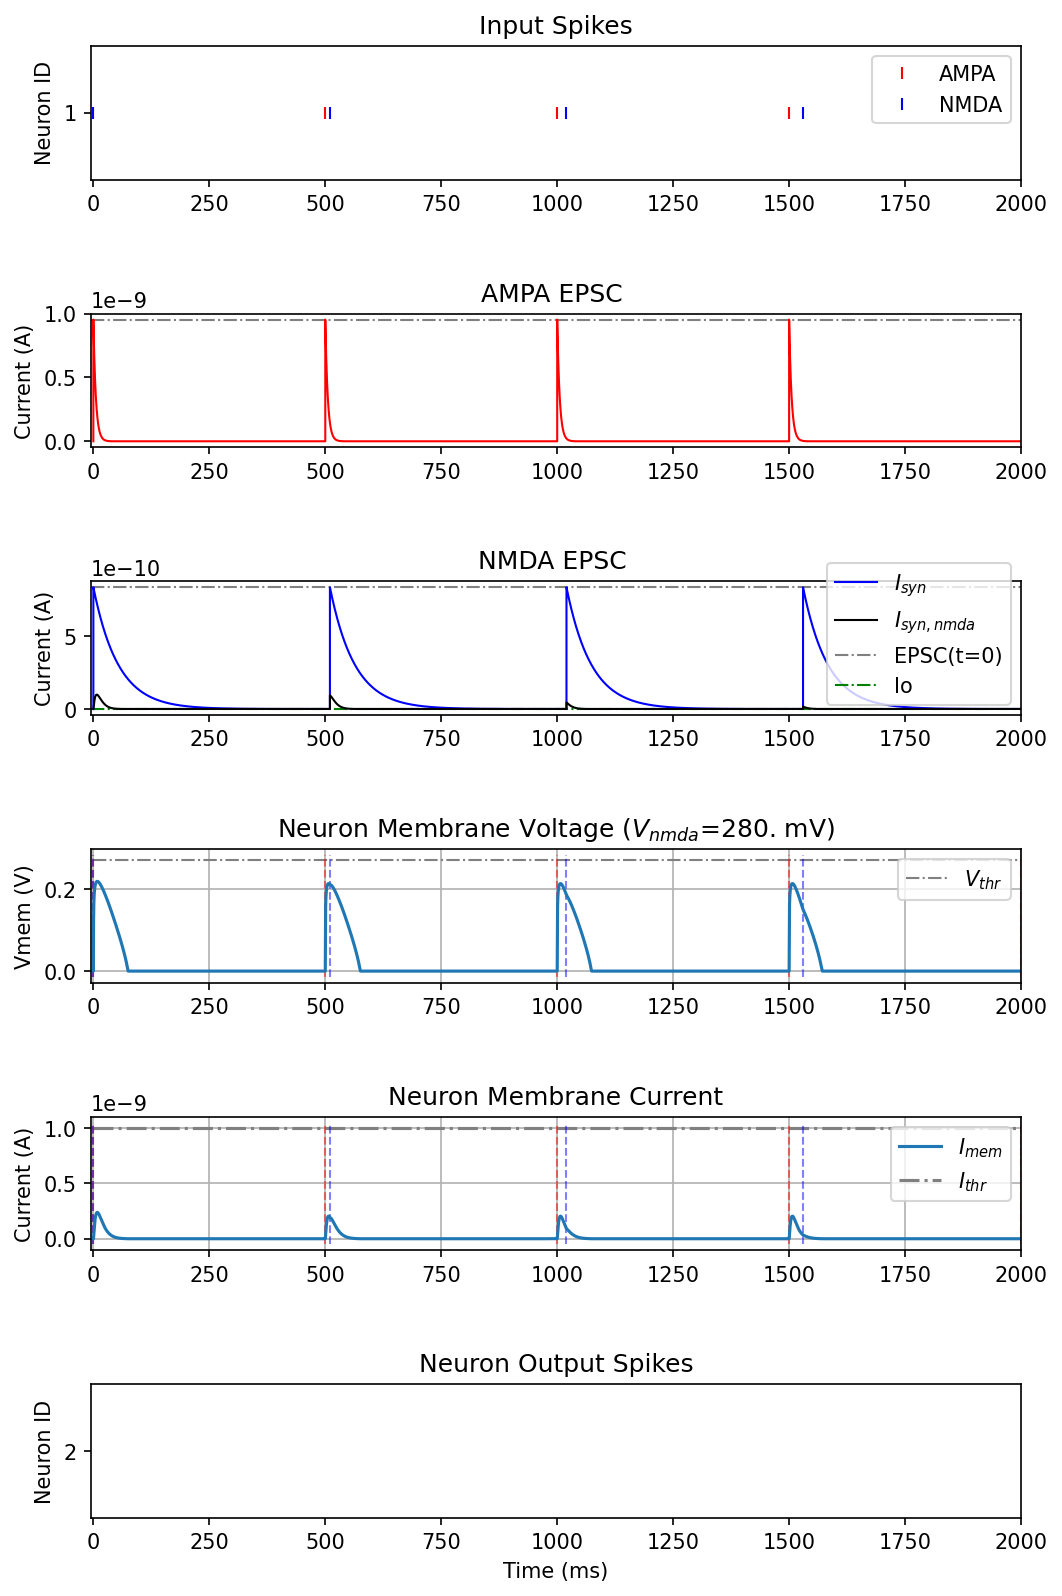

In [9]:
f = plt.figure(figsize=(8,13),dpi=150)
plt.subplots_adjust(hspace=1)
tstart = 0
tend   = int(duration*1000) # ms
Vthr = Ut/DPI_neuron.kappa*log(dynapse_param['Ispkthr']/Io)

# Input Spikes 
plt.subplot(611)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_ampa.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'r|', label='AMPA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_input_nmda.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'b|', label='NMDA')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.legend()
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
plt.xlim(-5, duration/ms)
#plt.xlabel('Time (ms)')

plt.subplot(612)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1, c='r')
plt.hlines(y=EPSC_t0_ampa[0]+Io, xmin=-5, xmax=duration/ms, color='grey', linestyles='-.', label='EPSC', linewidth=1)
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('AMPA EPSC ')

plt.subplot(613)
s = int(1*ms / defaultclock.dt)
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_synapse_nmda.I_syn_nmda[0][tstart*s:tend*s], linewidth=1, label='$I_{syn}$', c='b')
plt.plot(mon_neuron_I_syn_nmda.t[tstart*s:tend*s]/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0][tstart*s:tend*s], linewidth=1, c='k', label='$I_{syn,nmda}$')
plt.hlines(y=EPSC_t0[0]+Io, xmin=-5, xmax=duration/ms, color='grey', linestyles='-.', label='EPSC(t=0)', linewidth=1)
plt.hlines(y=Io, xmin=-5, xmax=duration/ms, color='green', linestyles='-.', label='Io', linewidth=1)
plt.legend()
plt.xlim(-5, duration/ms)
plt.ylabel('Current (A)')
plt.title('NMDA EPSC ')

plt.subplot(614)
plt.hlines(y=Vthr, xmin=0, xmax=duration/ms, color='grey', linestyles='-.', linewidth=1, label='$V_{thr}$')
plt.legend()
plt.plot(mon_neuron_state.t[tstart*s:tend*s]/ms, mon_neuron_vmem.Vmem[0][tstart*s:tend*s], linewidth=1.5)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.title('Neuron Membrane Voltage ($V_{nmda}$='+str(dynapse_param["Vnmda"])+')')
plt.ylabel('Vmem (V)')
plt.xlim(-5, duration/ms)
plt.grid(True)

plt.subplot(615)
Imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, Imem)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='grey', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlim(-5, duration/ms)
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=1)
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=1)
plt.grid(True)

plt.subplot(616)
spike_placeholder = np.zeros(5000)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.xlim(-5, duration/ms)
plt.show()

f.savefig('.fig/part5_DPI_coincidenceDetection_'+str(np.array(DPI_NMDA_synapse.Vnmda)[0])+'.pdf')

# Sweep Vnmda

110
126
142
158
174
190


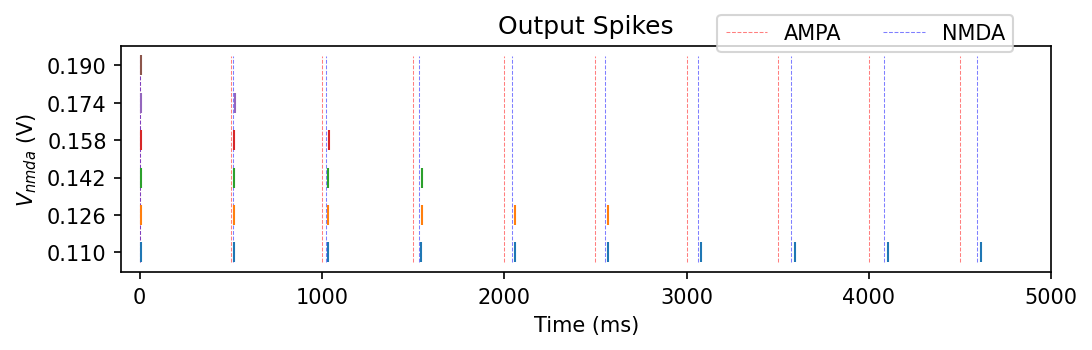

In [227]:
output_spikes = {}

network.restore()
dict_vmem = {}
dict_imem = {}
dict_inmda = {}
dict_out_spikes = {}

# Sweep V_nmda threshold values:
sampled_nmda = np.linspace(110, 190, 6).astype(int) #150

for vnmda in sampled_nmda:
    print('Vnmda: ', vnmda)
    dynapse_param['Vnmda'] = vnmda*mV
        
    for core in chip.cores:
        set_params(core.neurons, dynapse_param)
        
    # Simulation
    duration = inp_duration * 1000 * ms

    # Run
    network.run(duration)
    
    dict_inmda[vnmda] = (mon_neuron_I_syn_nmda.t/ms, mon_neuron_I_syn_nmda.I_syn_nmda_dp_clip[0])
    dict_imem[vnmda] = (mon_neuron_state.t/ms, mon_neuron_state.Imem[0])
    dict_vmem[vnmda] = (mon_neuron_vmem.t/ms, mon_neuron_vmem.Vmem[0])
    dict_out_spikes[vnmda] = mon_neuron_output.t/ms
    # (The next one does not depend on Vnmda)
    iampa = (mon_synapse_ampa.t/ms, mon_synapse_ampa.I_syn_ampa[0])
    
    network.restore()
    
# Plot output spikes:
f = plt.figure(figsize=(8,2),dpi=150)
plt.subplot(111)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
plt.title('Output Spikes')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.8, 1.18))

In [274]:
# For each pair of input ISI, label the pair of input spike with True if an output spike was generated. 
mask_out_spike = {}
for nmda in sampled_nmda:
    
    mask_out_spike[nmda] = np.zeros(len(spike_timing_ampa))
    # Loop over the spike times of the AMPA synapse
    for ii, t_ampa in enumerate(spike_timing_ampa/ms):
        # If any output spike is recorded during that time window:
        if len(np.where( np.logical_and( dict_out_spikes[nmda]>=t_ampa, dict_out_spikes[nmda]<(t_ampa+1/rate*1e3) ) )[0])>0:
            mask_out_spike[nmda][ii]=1
            
# This mask will be used in the following section

### Compare to DP characteristic

Let's now analyse the output spikes from the perspective of the DP characteristics. For that we will ignore for now the first pair of
AMPA,NMDA input spikes at time t=0 and focus our attention on the next 4 pair of spikes. 

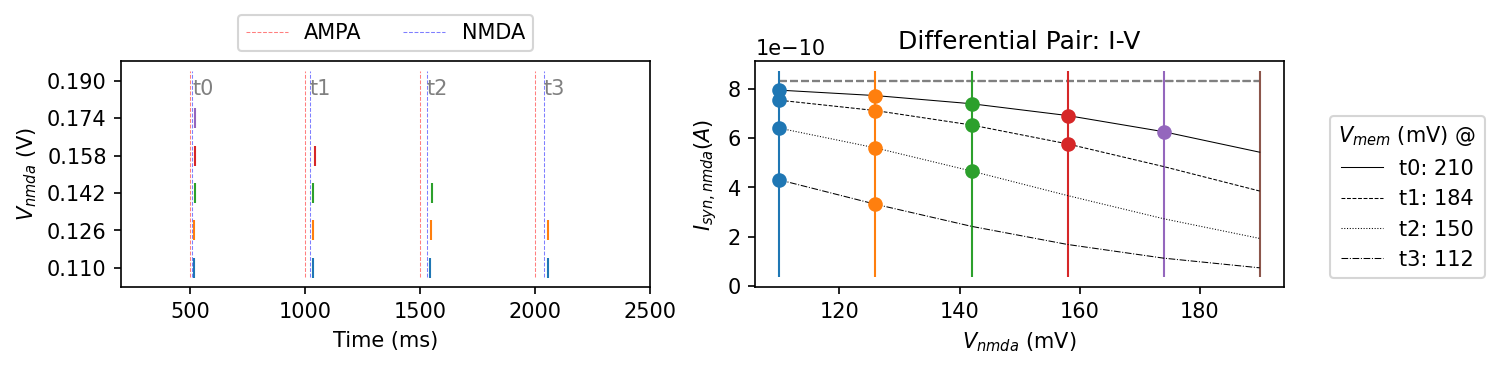

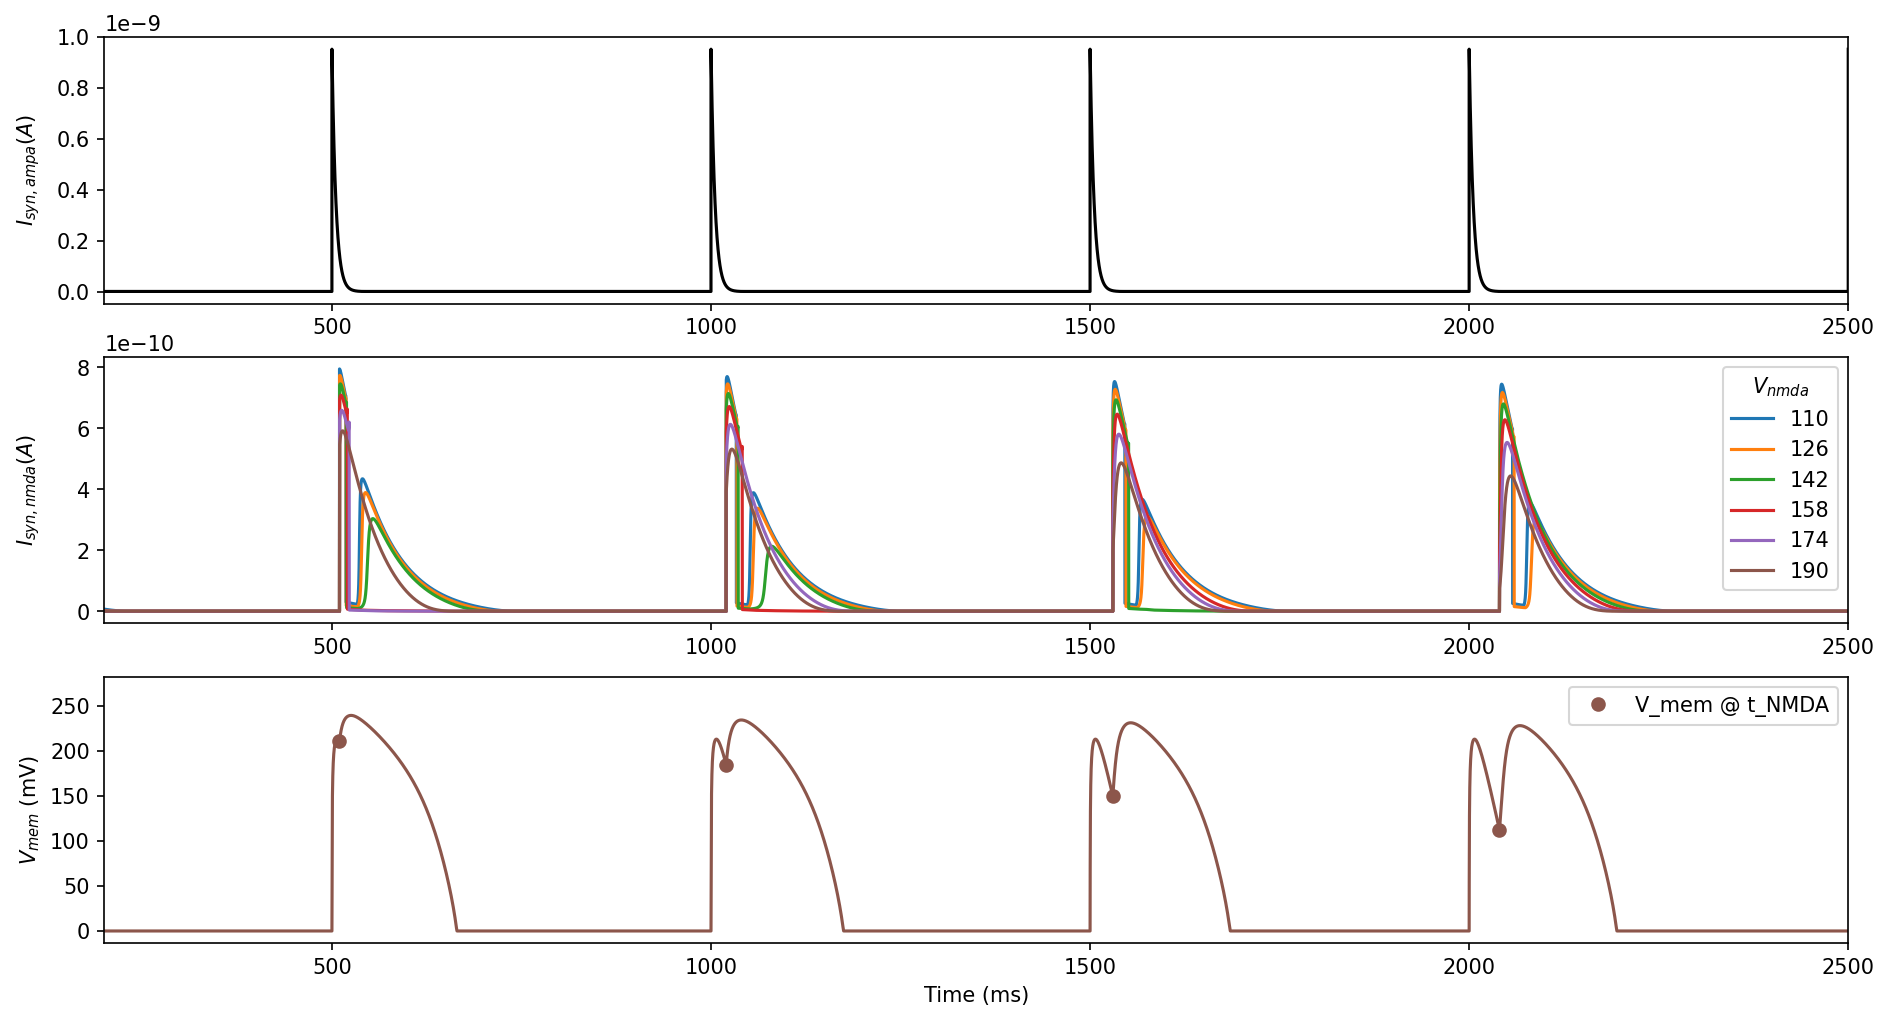

In [273]:
# Plot output spikes:
f = plt.figure(figsize=(10,2),dpi=150)

# Rasterplot
plt.subplot(121)
for i, vnmda in enumerate(sampled_nmda):
    spike_times = dict_out_spikes[vnmda]
    plt.plot(spike_times, [vnmda*mV]*len(spike_times), '|', c=colors[i], markersize=10)
plt.yticks(sampled_nmda*1e-3)
plt.xlim(-100, duration/ms)
plt.xlabel('Time (ms)')
plt.ylabel('$V_{nmda}$ (V)')
ylim = plt.ylim()
plt.vlines(spike_timing_ampa.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='r', alpha=.5, linewidth=.5, label='AMPA')
plt.vlines(spike_timing_nmda.tolist()/ms,ylim[0], ylim[1], linestyle='--', color='b', alpha=.5, linewidth=.5, label='NMDA')
plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(.5, 1.25))
plt.xlim(200,2500)

for ii, isi in enumerate(input_isi):
    plt.text(spike_timing_nmda[1+ii]/ms, ylim[-1]-.01, 't'+str(ii), c='grey')
    
# DPI Characteristics
I_syn = EPSC_t0
plt.subplot(122)
style = ['solid', 'dashed', 'dotted', 'dashdot']

# Range Vmem
t_vmem = dict_vmem[110][0]
vmem = dict_vmem[110][1]
idx_vmem_at_nmda = [np.where(t_vmem<=t_nmda)[0][-1] for t_nmda in spike_timing_nmda/ms]
vmem_at_nmda = vmem[idx_vmem_at_nmda]/mV

# I-Vnmda curves for a range of vmem values
for v, vmem in enumerate(vmem_at_nmda[1:5]):
    vmem = vmem*mV
    I_syn_nmda = I_syn/(1 + np.exp(kappa_n*(sampled_nmda*mV-vmem)/Ut))
    p = plt.plot(sampled_nmda, I_syn_nmda/nA*1e-9, linestyle=style[v],c='k', linewidth=.5, label='t'+str(v)+': '+str(int(vmem/mV)))
    plt.hlines(y=I_syn/nA*1e-9, xmin=sampled_nmda[0], xmax=sampled_nmda[-1], linestyle='--', color='grey', linewidth=1)

ylim = plt.ylim()
for i, vnmda in enumerate(sampled_nmda):
    plt.vlines(vnmda, ylim[0], ylim[1], linestyle='-', color=colors[i], linewidth=1)

plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.4, 0.4), title='$V_{mem}$ (mV) @')
plt.xlabel('$V_{nmda}$ (mV)')
plt.ylabel('$I_{syn,nmda} (A)$')
plt.title('Differential Pair: I-V')

# Label intersection between DP characteristic and Vnmda if an output spike was generated:
for vv, vmem in enumerate(vmem_at_nmda[1:5]):
    for nn, vnmda in enumerate(sampled_nmda):
        if mask_out_spike[vnmda][vv+1]==1: # +1 because we are skipping the first input pair of spikes
            I_syn_nmda = I_syn/(1 + np.exp(kappa_n*(vnmda-vmem)*mV/Ut))
            plt.plot(vnmda, I_syn_nmda, 'o', c=colors[nn])
            
# Plot Vmem, EPSC AMPA, and EPSC NMDA as a function of Vnmda
f = plt.figure(figsize=(15,8),dpi=150)
plt.subplot(3,1,1)
plt.plot(iampa[0], iampa[1], c='k')
plt.xlim(200,2500)
plt.ylabel('$I_{syn,ampa} (A) $')
plt.subplot(3,1,2)
for vnmda in sampled_nmda:
    plt.plot(dict_inmda[vnmda][0], dict_inmda[vnmda][1], label=str(vnmda))
plt.legend(title='$V_{nmda}$')
plt.xlim(200,2500)

plt.ylabel('$I_{syn,nmda} (A) $')
plt.subplot(3,1,3)
plt.plot(dict_vmem[sampled_nmda[-1]][0], dict_vmem[sampled_nmda[-1]][1]/mV, c=colors[len(sampled_nmda)-1])
plt.plot(spike_timing_nmda/ms,vmem_at_nmda, 'o', c=colors[len(sampled_nmda)-1], label='V_mem @ t_NMDA')
plt.legend()
plt.ylabel('$V_{mem}$ (mV)')
plt.xlim(200,2500)
plt.xlabel('Time (ms)')

f.align_ylabels()

As expected, the $V_{nmda}$ regulates the amount of $I_{nmda}$ that flows through the neuron $C_{mem}$ (and eventually makes the neuron fire) as a function of $V_{mem}$ at the time of the NMDA input spike: The higher $V_{mem}$ at the time of the NMDA spike, i.e. the shorter the input AMPA-NMDA ISI, the larger the fraction of injected $I_{nmda}$.

However, in this parameter configuration, the neuron sensitivity to the input ISI is regulated mostly by the AMPA EPSC (amplitude and tau) since the amplitude of the AMPA EPSC is one order of magnitude higher than the NMDA amplitude. 

$$I_{syn} = I_{AMPA} + I_{NMDA} \approx I_{AMPA}$$

The effect of the AMPA spike is to bring the Vmem right below the Vthr. When the NMDA input current comes in, even a little amount is enough to bring the Vmem closer to the spiking threshold and to make the neuron fire. In other words, as the AMPA EPSC is larger than the NMDA EPSC, the effect of the AMPA exponential decay as a function of time (which determines the value of $V_{mem}$ at the time of the NMDA spike) dominates over the $I_{nmda}$ modulation via the $V_{nmda}$ threshold and controls the neuron sensitivity to the input ISI.

### Let's now operate in a different regime